## San Francisco Data [Linear Regressions]

---

[San Francisco provides a wealth of data on the city to the public.](https://data.sfgov.org/) 

This Notebook is all about exploring this data and modeling interesting relationships with simple linear regressions. 

In the final section of the Notebook I explore concepts in **statistics** and **hypothesis testing**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from scipy import stats
from datetime import datetime

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.weightstats import DescrStatsW

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/Users/Smitty/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Smitty/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Exploring the San Francisco Assessor Dataset


---------
### CSV files (assessor_office Size: 250Mb):

**assessor_data_year1_year2 (Size: ~30Mb)** x 8 Files 2007-2008 to 2014-2015

    assessor_class_use_key (Size: 4Kb)

    assessor_exemption_key (Size: 4Kb)

    assessor_neighborhood_key (Size: 12Kb)

    assessor_data_key (Size: 4Kb)
    
 Datasets are related to assessed property values in san francisco

In [2]:
# Dataset Paths
sf_data_14 = './san_francisco/assessor_office/assessor_data_2014_2015.csv'
prop_class_type = './san_francisco/assessor_office/assessor_class_use_key.csv'
exemption_key = './san_francisco/assessor_office/assessor_exemption_key.csv'
neighbor_key = './san_francisco/assessor_office/assessor_neighborhood_key.csv'

# Load Datasets to Dataframes
sf_data_14 = pd.read_csv(sf_data_14, low_memory=False)
prop_type = pd.read_csv(prop_class_type)
exemption_key = pd.read_csv(exemption_key)
neighbor_key = pd.read_csv(neighbor_key)

# Convert col names to lowercase
sf_data_14.columns = [x.lower() for x in sf_data_14.columns]
prop_type.columns = [x.lower() for x in prop_type.columns]
exemption_key.columns = [x.lower() for x in exemption_key.columns]
neighbor_key.columns = [x.lower() for x in neighbor_key.columns]

# Clean property type data
prop_type.dropna(axis=0, inplace=True) # Droping NaN rows
prop_type = prop_type[prop_type.use != 'USE'] # Droping column header that's included in data

# Padding the codes in exemption/neighbor datasets
exemption_key.code = exemption_key.code.apply(lambda x: x.zfill(2))
neighbor_key.code = neighbor_key.code.apply(lambda x: x.zfill(3))

# Merging SF data on the keys
sf_data_14 = pd.merge(sf_data_14, prop_type, left_on='rp1clacde', right_on='class')
sf_data_14 = pd.merge(sf_data_14, exemption_key, left_on='exemptype', right_on='code')
sf_data_14 = pd.merge(sf_data_14, neighbor_key, left_on='rp1nbrcde', right_on='code')

In [3]:
sf_data_14.columns

Index([u'proploc', u'rp1nbrcde', u'rp1prclid', u'baselot', u'baselotsfx',
       u'rp1volume', u'rp1clacde', u'yrblt', u'baths', u'beds', u'rooms',
       u'storeyno', u'units', u'chgdate', u'remarkfla', u'kitchen', u'builtin',
       u'zone', u'consttype', u'depth', u'front', u'sqft', u'fba', u'larea',
       u'lotcode', u'reprisdate', u'rp1recdat1', u'rp1docno1', u'rp1docno2',
       u'rp1tracde', u'ownrprcnt', u'exemptype', u'rp1stacde', u'rp1exmvl2',
       u'rp1exmvl1', u'rollyear', u'recurrsald', u'rp1fxtval', u'rp1impval',
       u'rp1lndval', u'rp1pptval', u'use', u'desc', u'class', u'desc.1',
       u'code_x', u'description', u'district', u'code_y', u'neighborhood',
       u'boundries'],
      dtype='object')

In [4]:
# Selecting Columns of interest
sf_land_14 = sf_data_14[[u'yrblt', u'baths', u'beds', u'rooms', u'storeyno', 
                         u'units', u'sqft', u'ownrprcnt', u'rp1lndval', 
                         u'desc', u'class', u'district', u'neighborhood']]

In [5]:
sf_land_14.head(3).T

,0,1,2
yrblt,1961,1954,1915
baths,2,7,6
beds,0,0,0
rooms,8,21,32
storeyno,1,2,3
units,1,2,1
sqft,15080,14829,10373
ownrprcnt,1,1,1
rp1lndval,960081,392954,190150
desc,Commercial Misc,Commercial Misc,Single Family Residential


In [6]:
## Subseting data to contain Single Family Resident Condominiums of at least 200 sqft
mask = (sf_land_14.desc == 'Single Family Residential') & (sf_land_14['class'] == 'Z') & (sf_land_14.sqft >= 200)
sf_land_14 = sf_land_14.loc[mask, :]
sf_land_14.shape

(17172, 13)

In [7]:
# Investigating unique values 
print 'Unique Vals:\n'
print 'Baths:\n {}\n'.format(sf_land_14.baths.unique())
print 'Units:\n {}\n'.format(sf_land_14.units.unique())
print 'Rooms:\n {}\n'.format(sf_land_14.rooms.unique())

Unique Vals:

Baths:
 [ 2  1  3  0  4 10  6  5]

Units:
 [1 0 2]

Rooms:
 [   4    5    2    3    0    6    7    1    8   13 1353    9   10   15   11
  870   16   12  670   17  694]



In [8]:
## Bedrooms Capped at 10 for this analysis, removing 0 valued condos
mask2 = (sf_land_14.rooms <= 10) & (sf_land_14.yrblt > 1776) & (sf_land_14.yrblt < 2015) & (sf_land_14.rp1lndval != 0)
sf_land_14 = sf_land_14.loc[mask2, :]

In [9]:
sf_land_14.shape

(16969, 13)

In [10]:
# Creating an column for age of condo
sf_land_14['age'] = 2014 - sf_land_14.yrblt

In [11]:
sf_land_14.isnull().sum()

yrblt           0
baths           0
beds            0
rooms           0
storeyno        0
units           0
sqft            0
ownrprcnt       0
rp1lndval       0
desc            0
class           0
district        0
neighborhood    0
age             0
dtype: int64

In [12]:
sf_land_14.head()

,yrblt,baths,beds,rooms,storeyno,units,sqft,ownrprcnt,rp1lndval,desc,class,district,neighborhood,age
90,1979,2,0,4,0,1,850,0.5,144232,Single Family Residential,Z,8,North Beach,35
91,1979,2,2,4,1,1,850,0.5,405080,Single Family Residential,Z,8,North Beach,35
92,1979,2,0,4,0,1,850,1.0,187522,Single Family Residential,Z,8,North Beach,35
93,1979,2,0,5,0,1,1475,0.5,213334,Single Family Residential,Z,8,North Beach,35
94,1979,2,0,5,0,1,1475,1.0,438538,Single Family Residential,Z,8,North Beach,35


In [13]:
# Looking at the different districts
sf_land_14.district.value_counts()

9     4019
8     3160
5     3096
7     1967
6     1746
1     1081
10     642
4      611
3      340
2      307
Name: district, dtype: int64

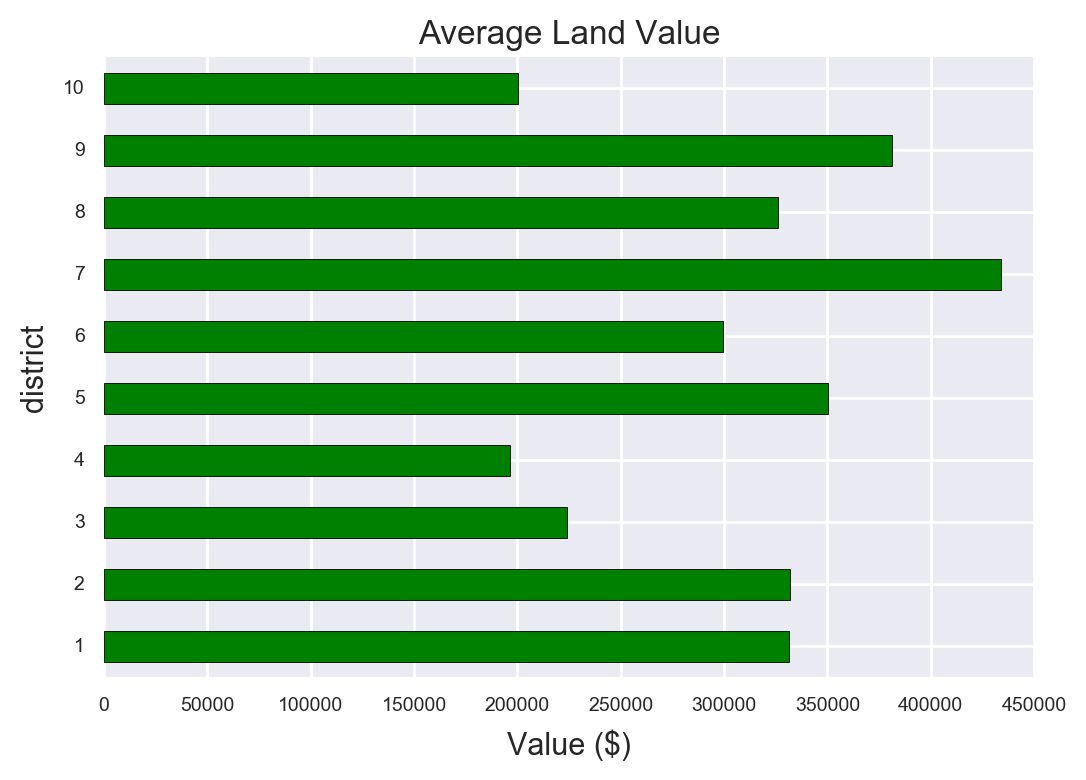

In [14]:
sf_land_14.groupby(by='district')['rp1lndval'].mean().plot(kind='barh', fontsize=7, color='g')
plt.title('Average Land Value')
plt.xlabel('Value ($)')
plt.show()

In [15]:
# Selecting specific District to model
distr = 9
mask3 = (sf_land_14.district == distr)
distr_val = sf_land_14.loc[mask3, :]

In [16]:
distr_val.head()

,yrblt,baths,beds,rooms,storeyno,units,sqft,ownrprcnt,rp1lndval,desc,class,district,neighborhood,age
3403,1980,1,2,4,1,1,970,0.5,266752,Single Family Residential,Z,9,Inner ission,34
3404,1980,1,2,4,1,1,1040,1.0,44824,Single Family Residential,Z,9,Inner ission,34
3405,1980,1,2,4,1,1,924,1.0,321160,Single Family Residential,Z,9,Inner ission,34
3406,1980,1,2,4,1,1,1040,0.5,343062,Single Family Residential,Z,9,Inner ission,34
3407,1980,1,1,3,1,1,667,1.0,79947,Single Family Residential,Z,9,Inner ission,34


### Hypothesis: 
Land Value assessment is determained mainly by the size of the condos 

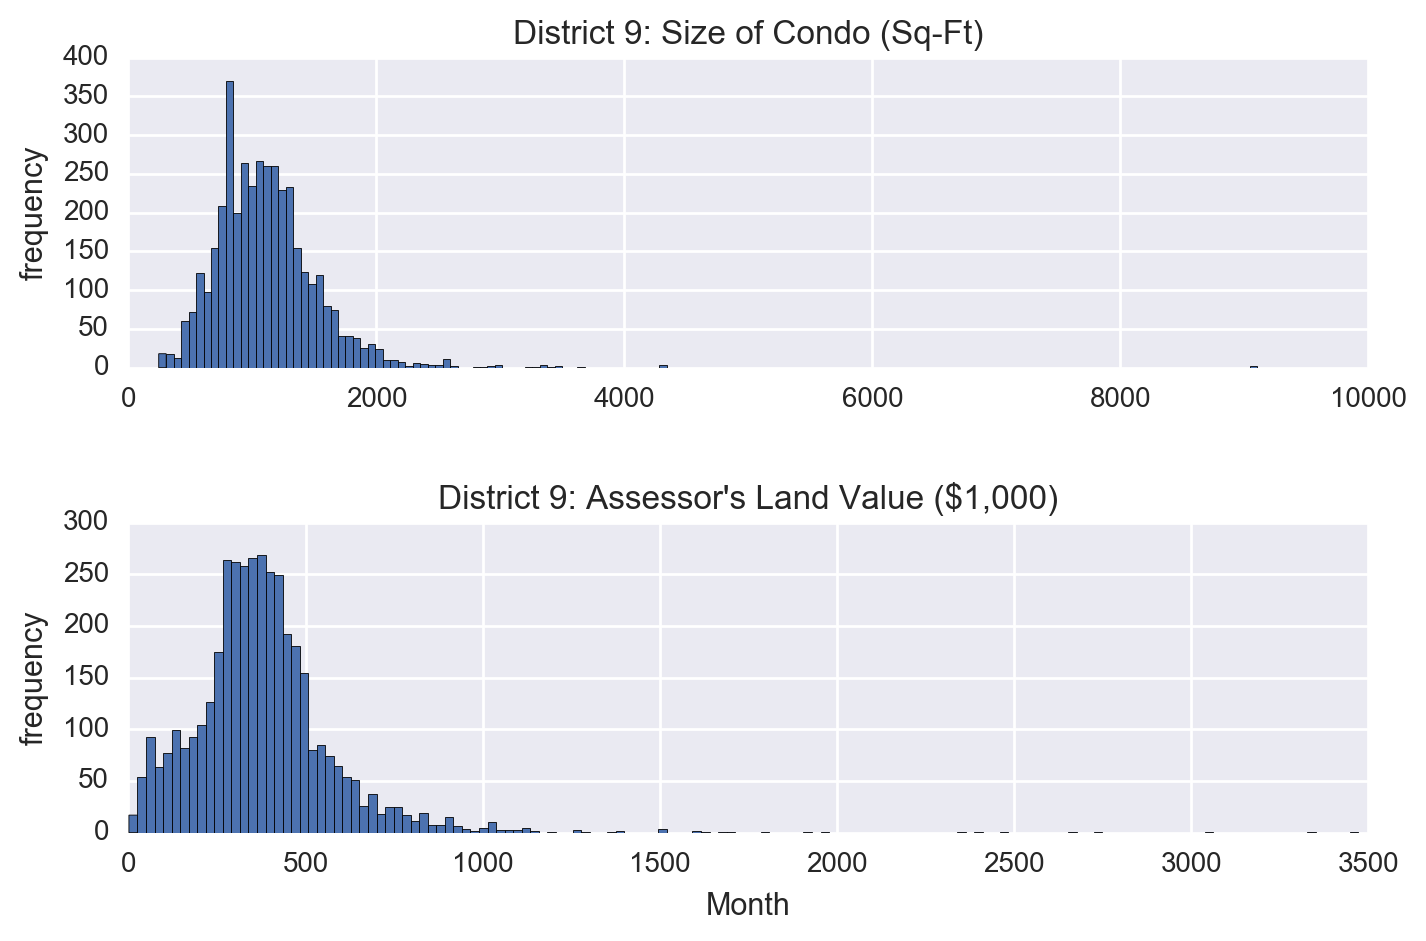

In [17]:
f, axarr = plt.subplots(2, figsize=(8,5))

x1 = distr_val.sqft
axarr[0].hist(x1, bins='auto')
axarr[0].set_title('District %s: Size of Condo (Sq-Ft)' %distr)
axarr[0].set_ylabel('frequency')

f.subplots_adjust(hspace=.5)

x2 = distr_val.rp1lndval / 1000
axarr[1].hist(x2, bins='auto')
axarr[1].set_title('District %s: Assessor\'s Land Value ($1,000)' %distr)
axarr[1].set_ylabel('frequency')

plt.xlabel('Month')

plt.show()

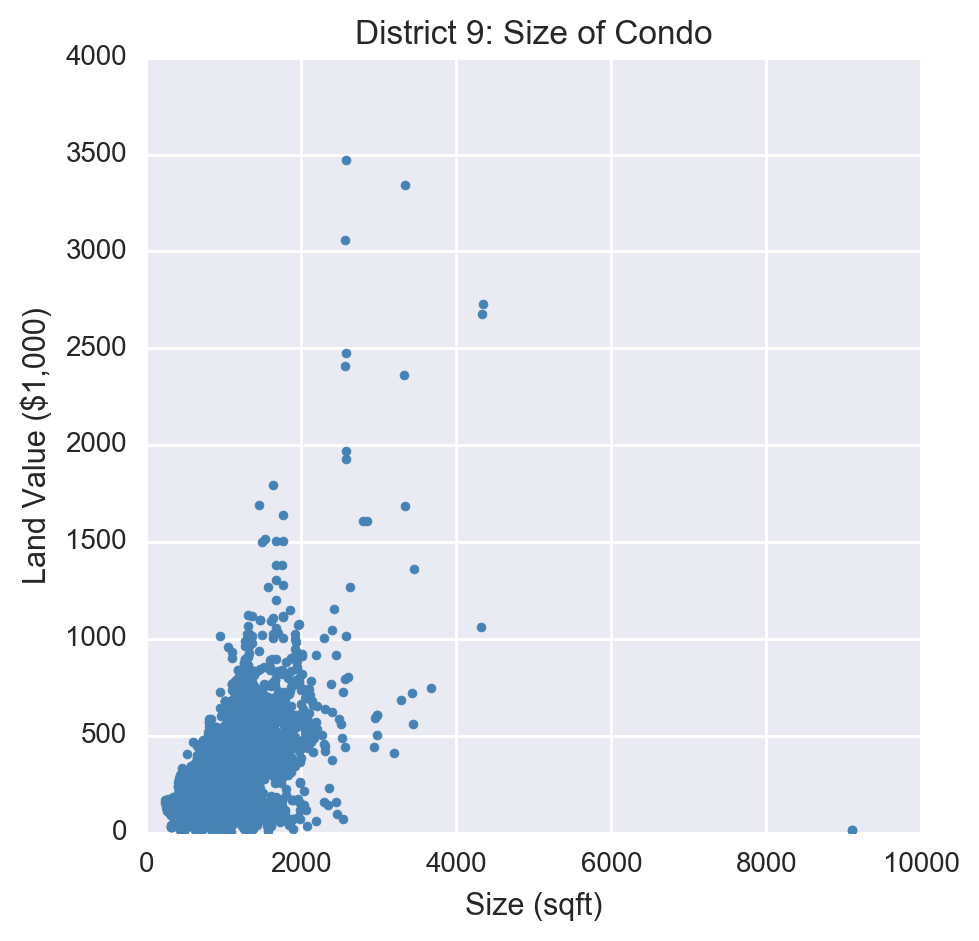

In [18]:
fig = plt.figure(figsize=(5,5))
ax = fig.gca()

x = distr_val.sqft
y = distr_val.rp1lndval / 1000

ax.scatter(x, y, color='steelblue', s=10)

ax.set_xlim([0, 10000])
ax.set_ylim([0, 4000])

ax.set_xlabel('Size (sqft)')
ax.set_ylabel('Land Value ($1,000)')
ax.set_title('District %s: Size of Condo' %distr)

#plt.legend()
plt.show()

Noticing at least 1 outlier at the bottom right of the scatter plot!

In [19]:
print 'Shape: {}'.format(distr_val.shape)
distr_val.loc[distr_val.sqft > 8000, :]

Shape: (4019, 14)


,yrblt,baths,beds,rooms,storeyno,units,sqft,ownrprcnt,rp1lndval,desc,class,district,neighborhood,age
3912,1904,1,0,5,2,1,9101,1.0,13359,Single Family Residential,Z,9,Inner ission,110
3913,1904,1,0,5,2,1,9101,1.0,13359,Single Family Residential,Z,9,Inner ission,110


In [20]:
distr_val = distr_val.loc[ ~((distr_val.sqft == 9101) & (distr_val.rp1lndval == 13359)), :]
distr_val.shape

(4017, 14)

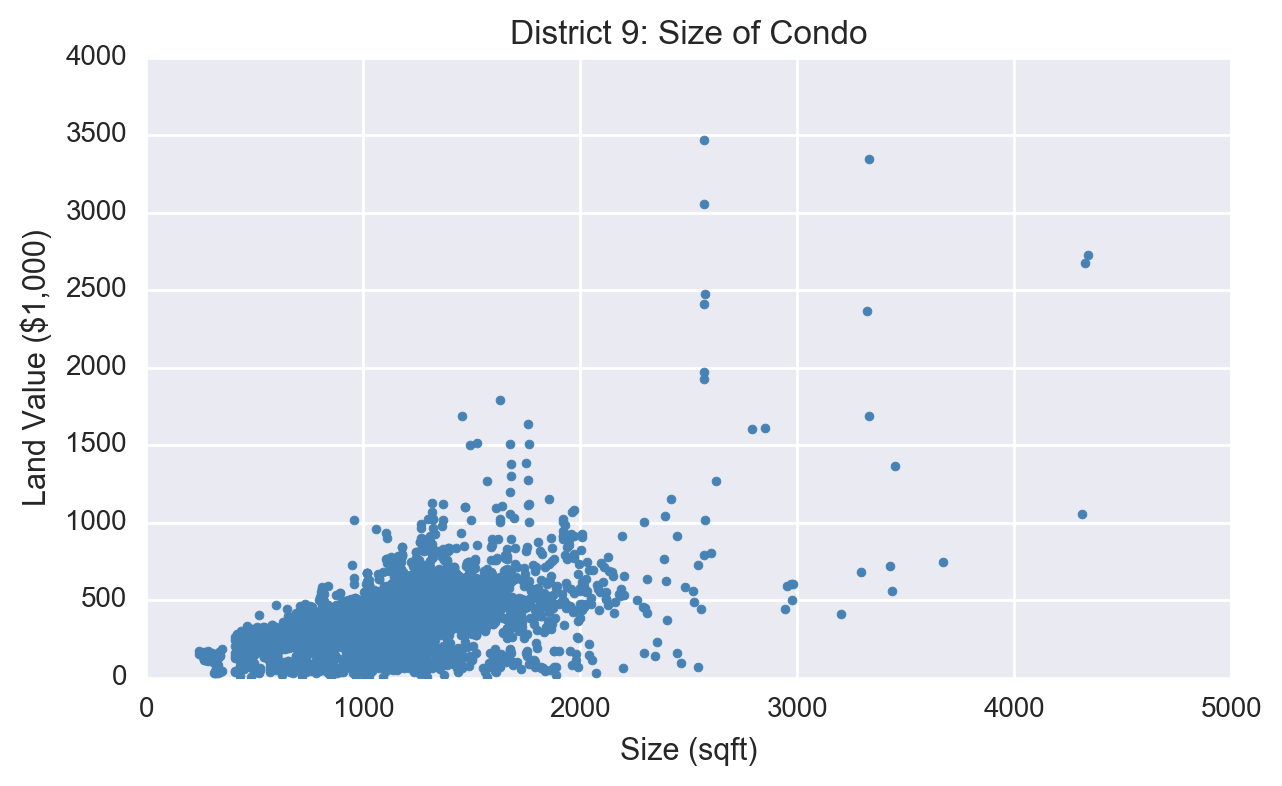

In [21]:
fig = plt.figure(figsize=(7,4))
ax = fig.gca()

x = distr_val.sqft
y = distr_val.rp1lndval / 1000

ax.scatter(x, y, color='steelblue', s=10)

#ax.set_xlim([0, 10000])
ax.set_ylim([0, 4000])

ax.set_xlabel('Size (sqft)')
ax.set_ylabel('Land Value ($1,000)')
ax.set_title('District %s: Size of Condo' %distr)

#plt.legend()
plt.show()

In [22]:
distr_val.describe()

,yrblt,baths,beds,rooms,storeyno,units,sqft,ownrprcnt,rp1lndval,district,age
count,4017.000000,4017.000000,4017.000000,4017.000000,4017.000000,4017.000000,4017.000000,4017.000000,4.017000e+03,4017.0,4017.000000
mean,1988.528255,1.363704,1.375156,2.874035,0.918347,0.395818,1108.907394,0.915978,3.816388e+05,9.0,25.471745
std,32.602974,0.771380,0.988686,2.179807,13.202446,0.489087,404.784608,0.192215,2.241641e+05,0.0,32.602974
min,1876.000000,0.000000,0.000000,0.000000,0.000000,0.000000,244.000000,0.000060,1.311000e+03,9.0,1.000000
25%,1991.000000,1.000000,1.000000,0.000000,0.000000,0.000000,830.000000,1.000000,2.689200e+05,9.0,7.000000
50%,2001.000000,1.000000,2.000000,3.000000,0.000000,0.000000,1069.000000,1.000000,3.605920e+05,9.0,13.000000
75%,2007.000000,2.000000,2.000000,5.000000,1.000000,1.000000,1311.000000,1.000000,4.610830e+05,9.0,23.000000
max,2013.000000,5.000000,6.000000,9.000000,591.000000,1.000000,4341.000000,1.000000,3.471682e+06,9.0,138.000000


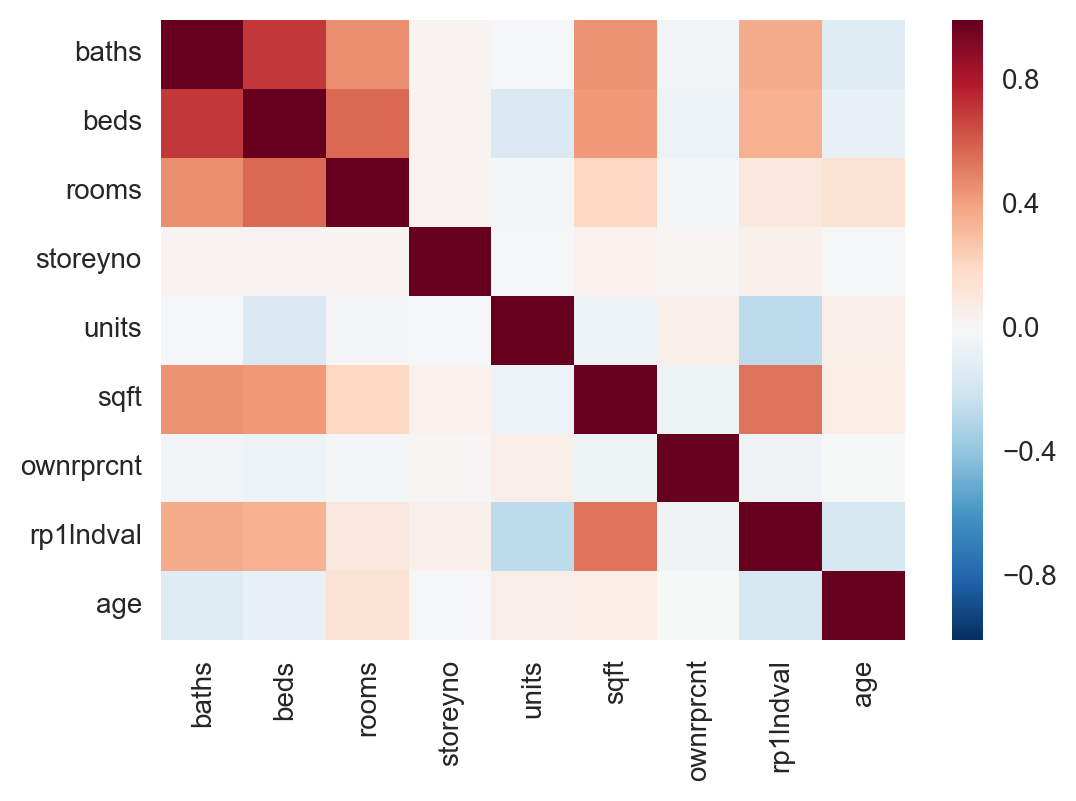

In [23]:
sns.heatmap(distr_val[[u'baths', u'beds', u'rooms', u'storeyno', u'units', u'sqft',
       u'ownrprcnt', u'rp1lndval', u'age']].corr())

plt.show()

### Constructing and Evaluate a Linear Regression Model on the Data

---

- Evaluating the model. How does the $R^2$ of the overall model compare to cross-validated $R^2$
  - Compare train / test split and  K-Folds 
- Visualize the evaluation metrics of your analysis in clear charts.

In [24]:
# Target and Predictor Variables
X = distr_val[['baths', 'beds', 'sqft']].values
y = distr_val.rp1lndval.values

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=4)

linreg = LinearRegression()
linreg.fit(X_train, Y_train)
linreg.coef_

array([ 33331.4002124 ,  18594.91411729,    261.55955036])

In [26]:
y_hat = linreg.predict(X_test)

In [27]:
mse = mean_squared_error(Y_test, y_hat)
print 'MSE: {}'.format(mse)
print 'R-2 Val. {}'.format(linreg.score(X_train, Y_train))

MSE: 36085697840.3
R-2 Val. 0.339057790467


--------------
**Using Cross Validation**

In [28]:
lr = LinearRegression()
lr_scores = cross_val_score(lr, X, y, cv=10, scoring = 'r2')
lr.fit(X, y)

print 'R-2 Scores: {}'.format(lr_scores)
print 'R-2 Score Avg.: {}'.format(np.mean(lr_scores))

R-2 Scores: [-0.12409882 -0.20034034  0.36598707  0.07422281 -0.45773052  0.18248613
  0.36962253  0.22853042  0.21685087  0.24750108]
R-2 Score Avg.: 0.0903031219565


**Plots**

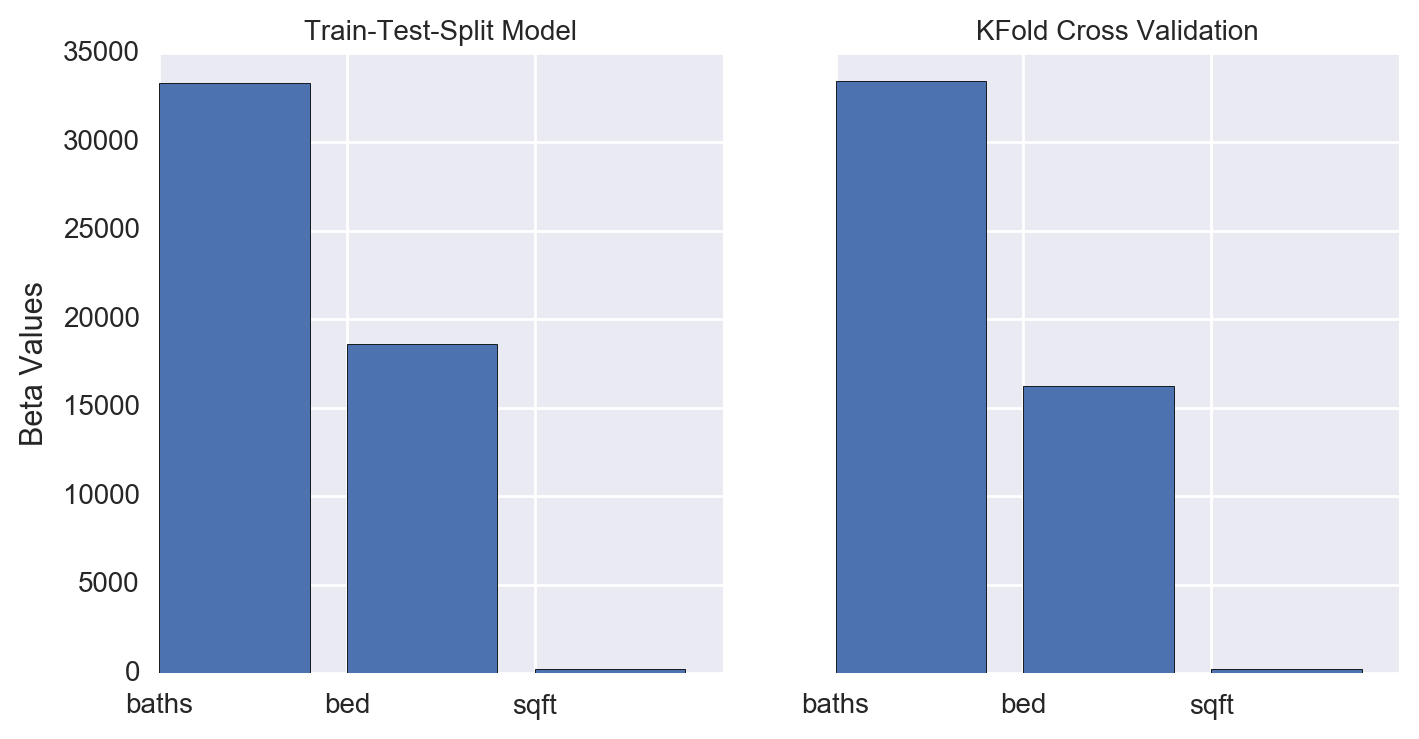

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,4))


# Train_Test_Split
x1 = [1, 2, 3]
y1 = linreg.coef_
ax1.set_ylabel('Beta Values')
ax1.bar(x1, y1)
ax1.set_xticks(x1)
ax1.set_xticklabels(['baths', 'bed', 'sqft'])
ax1.set_title('Train-Test-Split Model', fontsize=10)


# Cross Validation
x2 = [1, 2, 3]
y2 = lr.coef_

ax2.bar(x2, y2)
ax2.set_xticks(x2)
ax2.set_xticklabels(['baths', 'bed', 'sqft'])
ax2.set_title('KFold Cross Validation', fontsize=10)

plt.show()

### Combining Crime and Fire incidents datasets from the  San Francisco data to predict number of fire incidents. 

In [30]:
# Fire Data
fire_incidents = '/Users/Smitty/Desktop/san_francisco/Fire_Incidents.csv'

# Load Datasets to Dataframes
fire_incidents = pd.read_csv(fire_incidents, low_memory=False)

# Clean Column Names
fire_incidents.columns = [x.lower() for x in fire_incidents.columns]
fire_incidents.columns = [x.strip().replace(' ', '_') for x in fire_incidents.columns]

In [31]:
fire_incidents.columns

Index([u'incident_number', u'exposure_number', u'address', u'incident_date',
       u'call_number', u'alarm_dttm', u'arrival_dttm', u'close_dttm', u'city',
       u'zipcode', u'battalion', u'station_area', u'box', u'suppression_units',
       u'suppression_personnel', u'ems_units', u'ems_personnel',
       u'other_units', u'other_personnel', u'first_unit_on_scene',
       u'estimated_property_loss', u'estimated_contents_loss',
       u'fire_fatalities', u'fire_injuries', u'civilian_fatalities',
       u'civilian_injuries', u'number_of_alarms', u'primary_situation',
       u'mutual_aid', u'action_taken_primary', u'action_taken_secondary',
       u'action_taken_other', u'detector_alerted_occupants', u'property_use',
       u'area_of_fire_origin', u'ignition_cause', u'ignition_factor_primary',
       u'ignition_factor_secondary', u'heat_source', u'item_first_ignited',
       u'human_factors_associated_with_ignition', u'structure_type',
       u'structure_status', u'floor_of_fire_origin', 

In [32]:
# Subsetting for columns that are numerical
fire_num_data = fire_incidents.loc[:, (fire_incidents.dtypes == np.float64) | (fire_incidents.dtypes == np.int64)]

print 'Fire Incidents Shape: {}'.format(fire_incidents.shape)
print 'Fire Numerical Data Shape: {}'.format(fire_num_data.shape)

Fire Incidents Shape: (424635, 63)
Fire Numerical Data Shape: (424635, 24)


In [33]:
# Concatenating the numerical columns with the incident date column
fire_num_data = pd.concat([fire_num_data, fire_incidents.incident_date], axis=1)

fire_num_data.shape

(424635, 25)

In [34]:
# "Hand wavey" way of picking and choosing which columns to include in the final analysis
fire_num_data = fire_num_data[[u'incident_number', u'incident_date', u'exposure_number',
       u'suppression_units', u'suppression_personnel', u'ems_units',
       u'ems_personnel', u'other_units', u'other_personnel',
       u'estimated_property_loss', u'estimated_contents_loss',
       u'fire_fatalities', u'fire_injuries', u'civilian_fatalities',
       u'civilian_injuries',
       u'number_of_floors_with_minimum_damage',
       u'number_of_floors_with_significant_damage',
       u'number_of_floors_with_heavy_damage',
       u'number_of_floors_with_extreme_damage',
       u'number_of_sprinkler_heads_operating']]

In [35]:
# Converting Date to Datetime
fire_num_data.incident_date = fire_num_data.incident_date.apply(lambda x: datetime(int(x[-4:]), 
                                                                                   int(x[:2]), int(x[3:5])))

# Creating Month and Year columns
fire_num_data['year'] = fire_num_data.incident_date.dt.year
fire_num_data['month'] = fire_num_data.incident_date.dt.month

In [36]:
fire_num_data.columns

Index([u'incident_number', u'incident_date', u'exposure_number',
       u'suppression_units', u'suppression_personnel', u'ems_units',
       u'ems_personnel', u'other_units', u'other_personnel',
       u'estimated_property_loss', u'estimated_contents_loss',
       u'fire_fatalities', u'fire_injuries', u'civilian_fatalities',
       u'civilian_injuries', u'number_of_floors_with_minimum_damage',
       u'number_of_floors_with_significant_damage',
       u'number_of_floors_with_heavy_damage',
       u'number_of_floors_with_extreme_damage',
       u'number_of_sprinkler_heads_operating', u'year', u'month'],
      dtype='object')

In [37]:
# GroupBy dates
fire_grouped = fire_num_data.groupby(by='incident_date')[[u'incident_date', u'exposure_number',
       u'suppression_units', u'suppression_personnel', u'ems_units',
       u'ems_personnel', u'other_units', u'other_personnel',
       u'estimated_property_loss', u'estimated_contents_loss',
       u'fire_fatalities', u'fire_injuries', u'civilian_fatalities',
       u'civilian_injuries', u'number_of_floors_with_minimum_damage',
       u'number_of_floors_with_significant_damage',
       u'number_of_floors_with_heavy_damage',
       u'number_of_floors_with_extreme_damage',
       u'number_of_sprinkler_heads_operating']].sum().reset_index()

In [38]:
# Incident Counts
incident_count = fire_num_data.groupby(by='incident_date')[['incident_date']].count()
incident_count.columns = [u'incidents']
incident_count.reset_index(inplace=True)

# Merge df of counts to fire dataframe
fire_grouped = pd.merge(fire_grouped, incident_count, left_on='incident_date', right_on='incident_date')

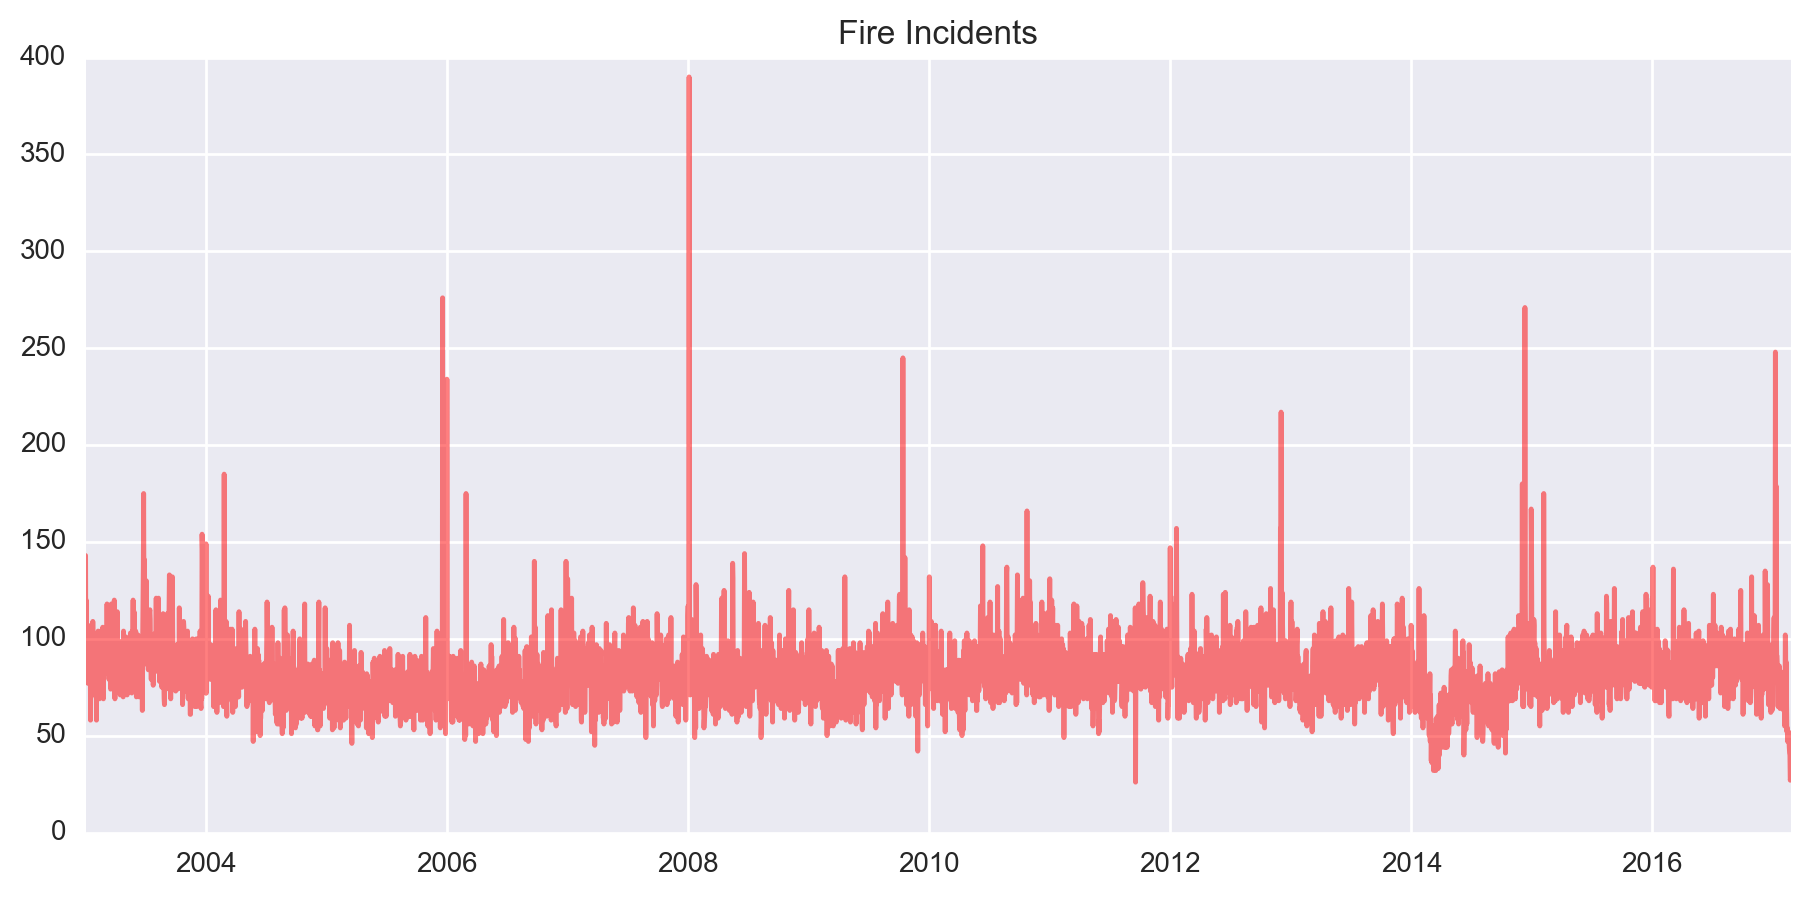

In [39]:
fig = plt.figure(figsize=(11,5))
ax = fig.gca()

x = fire_grouped.incident_date
y = fire_grouped.incidents


ax.set_title('Fire Incidents')
ax.plot(x,y, color='r', alpha=0.5)

plt.show()

In [40]:
fire_grouped.isnull().sum()

incident_date                                  0
exposure_number                                0
suppression_units                              0
suppression_personnel                          0
ems_units                                      0
ems_personnel                                  0
other_units                                    0
other_personnel                                0
estimated_property_loss                      299
estimated_contents_loss                       70
fire_fatalities                                0
fire_injuries                                  0
civilian_fatalities                            0
civilian_injuries                              0
number_of_floors_with_minimum_damage        1962
number_of_floors_with_significant_damage    1969
number_of_floors_with_heavy_damage          1970
number_of_floors_with_extreme_damage        1969
number_of_sprinkler_heads_operating         1900
incidents                                      0
dtype: int64

In [41]:
# Replacing property loss and contents loss columns with median values
fire_grouped.estimated_property_loss.replace(np.nan, fire_grouped.estimated_property_loss.median(), inplace=True)
fire_grouped.estimated_contents_loss.replace(np.nan, fire_grouped.estimated_contents_loss.median(), inplace=True)

In [42]:
# Replacong damage columns with median value
fire_grouped.number_of_floors_with_minimum_damage.replace(np.nan, fire_grouped.number_of_floors_with_minimum_damage.mean(), inplace=True)
fire_grouped.number_of_floors_with_significant_damage.replace(np.nan, fire_grouped.number_of_floors_with_significant_damage.mean(), inplace=True)
fire_grouped.number_of_floors_with_heavy_damage.replace(np.nan, fire_grouped.number_of_floors_with_heavy_damage.mean(), inplace=True)
fire_grouped.number_of_floors_with_extreme_damage.replace(np.nan, fire_grouped.number_of_floors_with_extreme_damage.mean(), inplace=True)
fire_grouped.number_of_sprinkler_heads_operating.replace(np.nan, fire_grouped.number_of_sprinkler_heads_operating.mean(), inplace=True)

---------
**Status: Fire Data is cleaned, can now run regression model**
______

In [43]:
# Sep dataframe for predictors and targets
X_cols = fire_grouped[fire_grouped.columns[1:-1]]
y_col = fire_grouped[fire_grouped.columns[-1]]

# Converting DataFrame data to array format
X = X_cols.values
y = y_col.values

**Linear Regression**

In [44]:
lr = LinearRegression()
lr_scores = cross_val_score(lr, X, y, cv=10, scoring = 'r2')
lr.fit(X, y)

print 'R-2 Scores: {}'.format(lr_scores)
print 'R-2 Score Avg.: {}'.format(np.mean(lr_scores))

R-2 Scores: [-0.71248892  0.05805935  0.10330197  0.37244782  0.08449502  0.4475506
 -1.00338138  0.373524   -0.57468251  0.5069192 ]
R-2 Score Avg.: -0.034425483498


**Regularization Models**
    
Will normalize the data to use for these models

In [45]:
ss = StandardScaler()

# Using fit_transform to normalize the design matrix
Xn = ss.fit_transform(X_cols)

**Ridge**

In [46]:
# Finding optimal value for Ridge regression alpha

ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xn, y)

print optimal_ridge.alpha_

2768.28663039


In [47]:
# Cross validate the Ridge R-2 with the optimal alpha
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xn, y, cv=10)

print ridge_scores
print np.mean(ridge_scores)

[-0.20070381  0.04187991  0.33888734  0.28858123  0.20860111  0.34325568
 -0.09247966  0.28810827  0.2010011   0.3893335 ]
0.180646465293


**Lasso**

In [48]:
# Finding optimal value for Lasso regression alpha
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xn, y)

print optimal_lasso.alpha_

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

1.43664986249


..............................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished


In [49]:
# Cross validate the Lasso R-2 with the optimal alpha
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xn, y, cv=10)

print lasso_scores
print np.mean(lasso_scores)

[-0.2969699  -0.04503674  0.36556698  0.33093323  0.09359654  0.37769236
 -0.64553923  0.34065241  0.30545696  0.40505557]
0.123140817558


**ElasticNet**

In [50]:
# Find optimal value for ElasticNet
l1_ratios = np.linspace(0.01, 1.0, 50)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=300, cv=5, verbose=1)

optimal_enet.fit(Xn, y)

print optimal_enet.alpha_
print optimal_enet.l1_ratio_

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.624086126781
0.353469387755


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   14.8s finished


In [51]:
# Cross validate the ElasticNet R-2 with the optimal alpha and l1 ratio
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, Xn, y, cv=10)

print enet_scores
print np.mean(enet_scores)

[-0.23879773  0.04773885  0.36193999  0.30523347  0.19100508  0.36164002
 -0.19195585  0.3078707   0.2407271   0.40856291]
0.179396453664


**Summary of Models**

In [52]:
models = ['LinearReg', 'Ridge', 'Lasso', 'ElasticNet']
r_sq = [np.mean(lr_scores), np.mean(ridge_scores), np.mean(lasso_scores), np.mean(enet_scores)]
pd.DataFrame(zip(models, r_sq), columns=['model', 'r_sq'])

,model,r_sq
0,LinearReg,-0.034425
1,Ridge,0.180646
2,Lasso,0.123141
3,ElasticNet,0.179396


In [53]:
# Fitting the models
ridge.fit(Xn, y)
lasso.fit(Xn, y)
enet.fit(Xn, y)

# Calculating residuals
ridge_resid = y - ridge.predict(Xn)
lasso_resid = y - lasso.predict(Xn)
enet_resid = y - enet.predict(Xn)

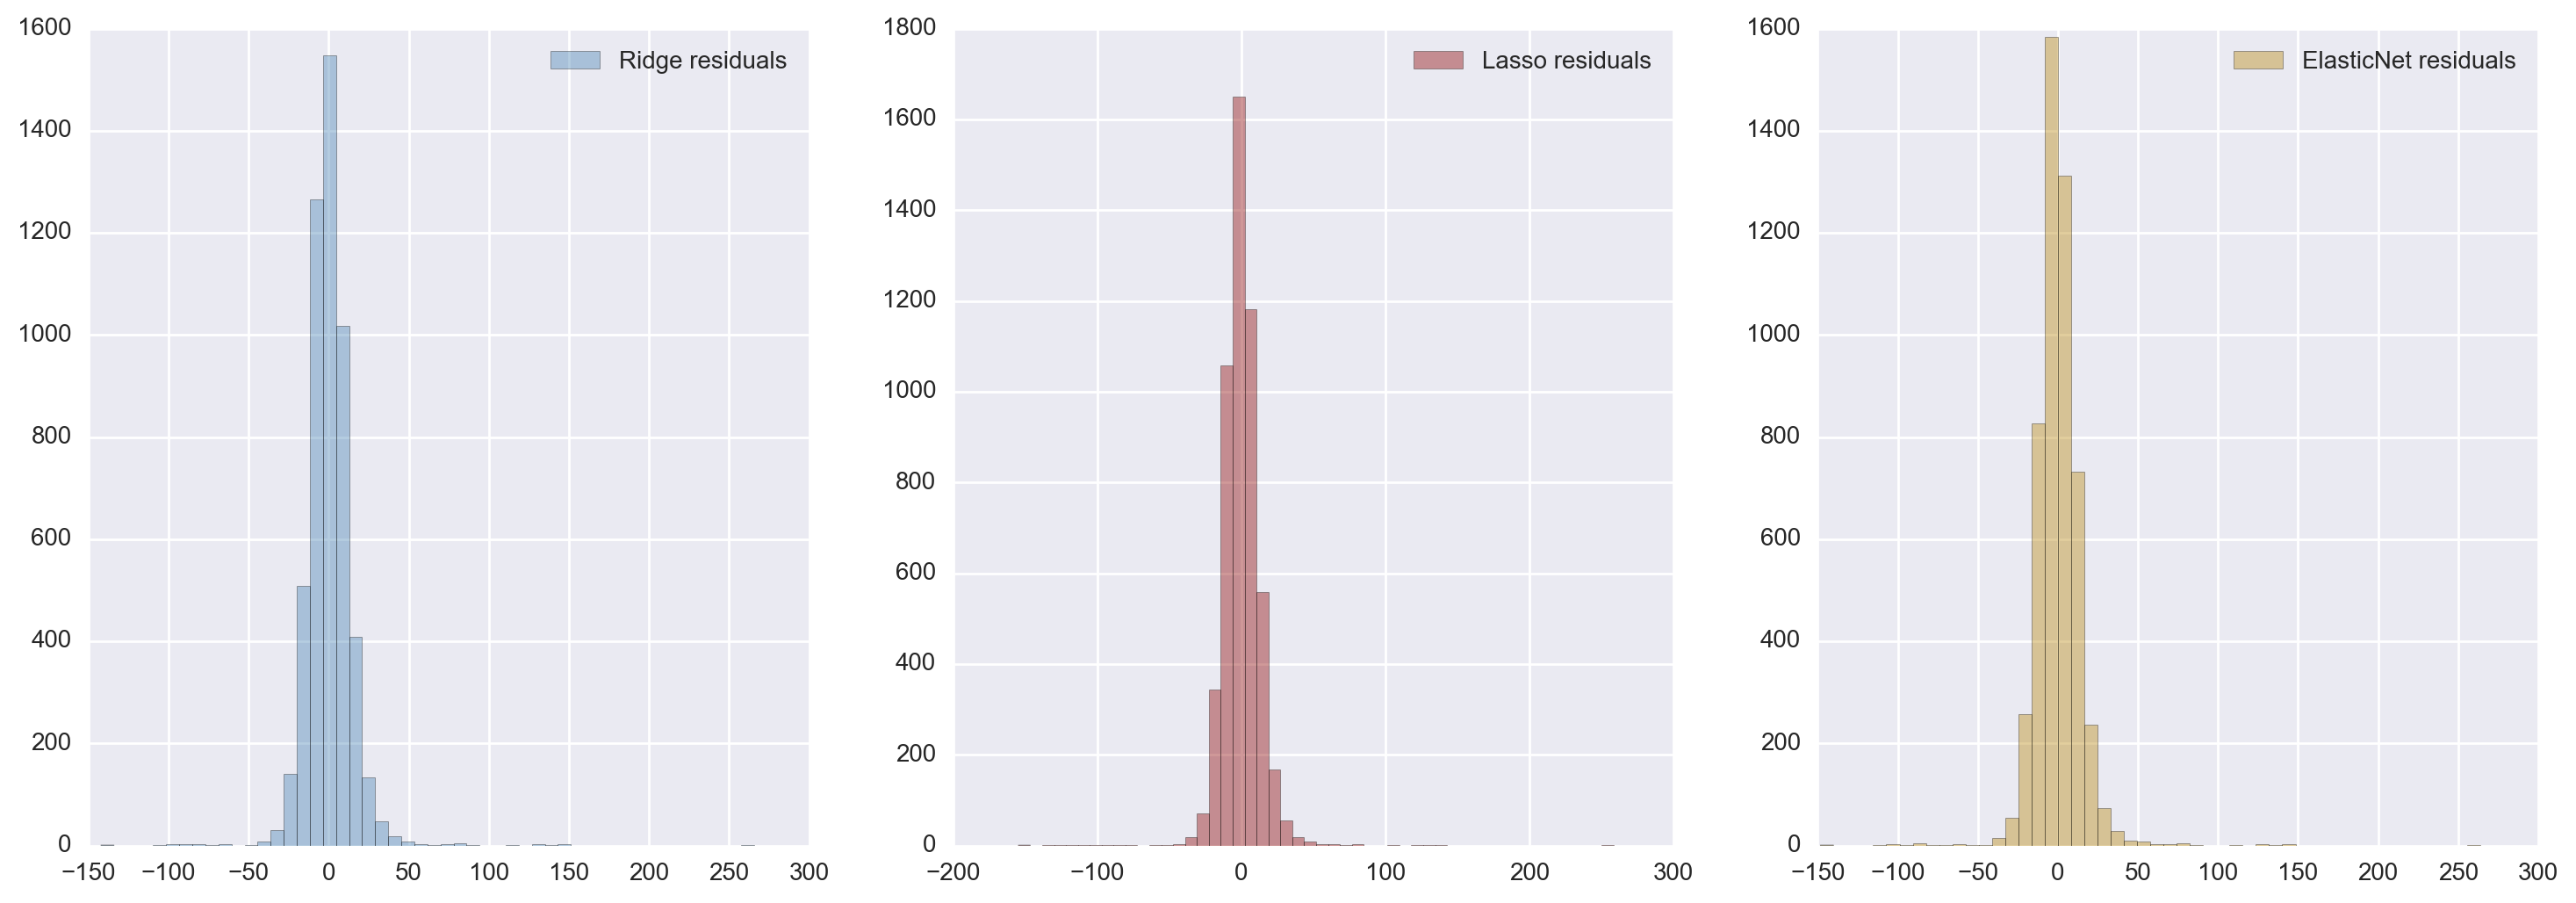

In [54]:
# Plotting the residuals

fig, axarr = plt.subplots(1, 3, figsize=(18, 6))

sns.distplot(ridge_resid, bins=50, hist=True, kde=False, 
             color='steelblue', ax=axarr[0], label='Ridge residuals')

sns.distplot(lasso_resid, bins=50, hist=True, kde=False, 
             color='darkred', ax=axarr[1], label='Lasso residuals')

sns.distplot(enet_resid, bins=50, hist=True, kde=False, 
             color='darkgoldenrod', ax=axarr[2], label='ElasticNet residuals')

axarr[0].legend()
axarr[1].legend()
axarr[2].legend()

plt.show()

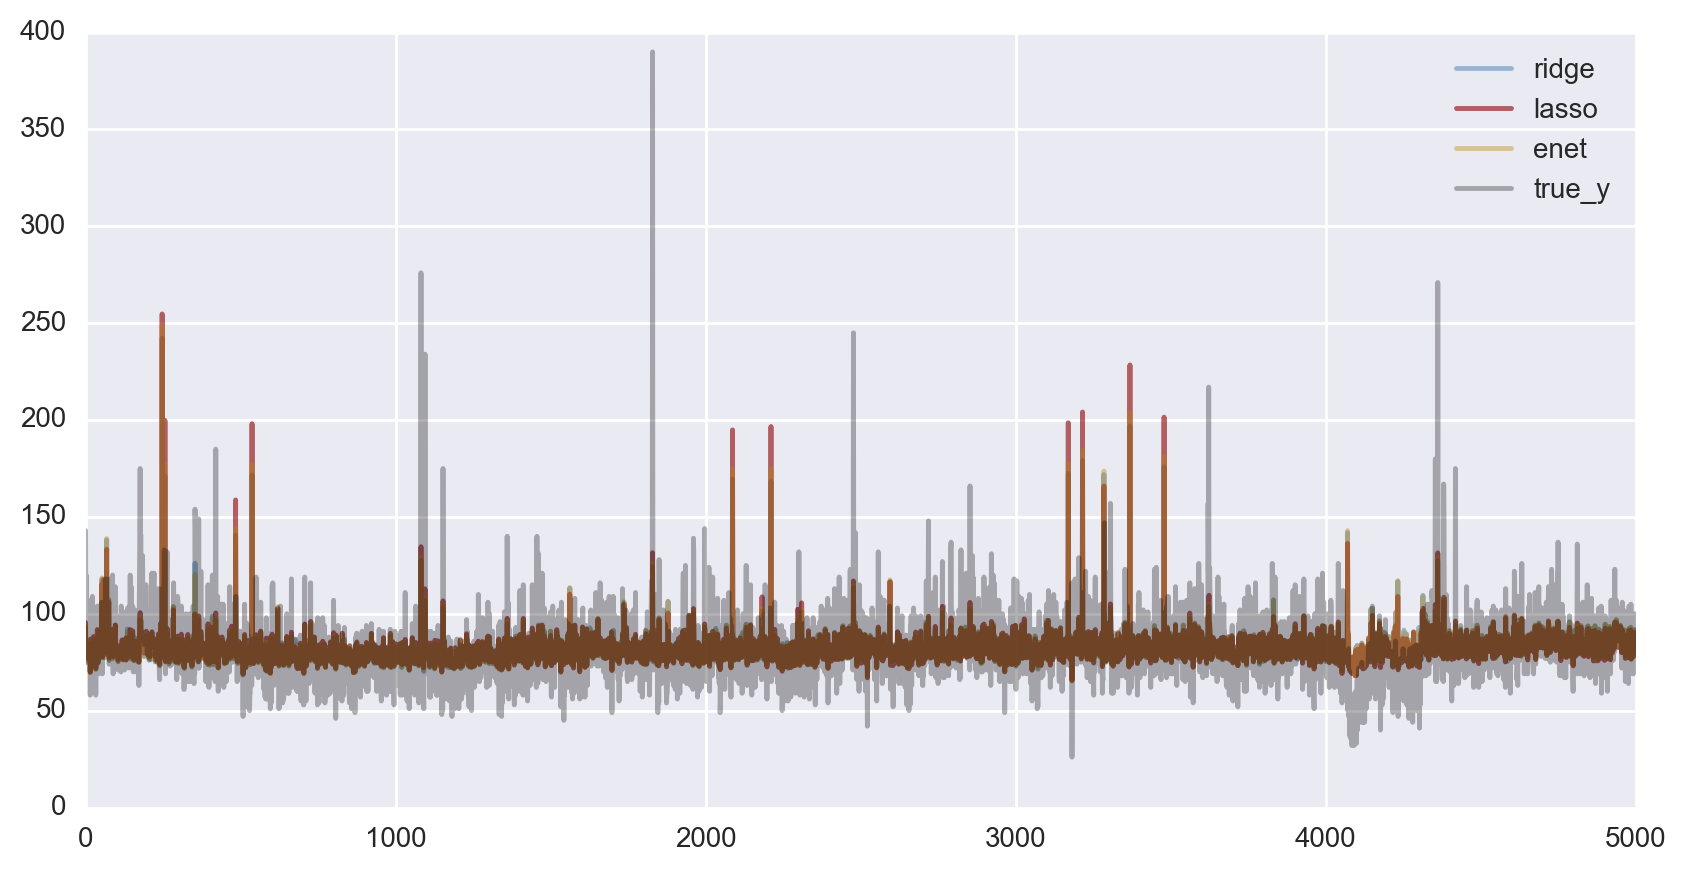

In [55]:
# Plotting the different models
fig, ax = plt.subplots(figsize=(10,5))

x_axis = range(len(y))

plt.plot(x_axis, ridge.predict(Xn), label='ridge', alpha=0.5, color='steelblue')
plt.plot(x_axis, lasso.predict(Xn), label='lasso', alpha=0.6, color='darkred')
plt.plot(x_axis, enet.predict(Xn), label='enet', alpha=0.4, color='darkgoldenrod')
plt.plot(x_axis, y, label='true_y', alpha=0.3, color='black')

plt.xlim(0, 5000)

plt.legend()
plt.show()

### Conducting another analysis using the San Francisco Parks data to predict Park scores

In [56]:
# Datasets Paths
park_donations = './san_francisco/parks/park_donations.csv'
park_info = './san_francisco/parks/park_info.csv'
park_scores = './san_francisco/parks/park_scores.csv'

# Load Datasets to Dataframes
park_donations = pd.read_csv(park_donations)
park_info = pd.read_csv(park_info)
park_scores = pd.read_csv(park_scores)

# Convert col names to lowercase
park_donations.columns = [x.strip().replace(' ', '_').lower() for x in park_donations.columns]
park_info.columns = [x.strip().replace(' ', '_').lower() for x in park_info.columns]
park_scores.columns = [x.strip().replace(' ', '_').lower() for x in park_scores.columns]

In [57]:
park_donations.head()

,close_date,account_name,description,amount,type
0,07/08/2014 12:00:00 AM,Glen Park Association,To support botanical signs at the Sunnyside Co...,$500.00,Cash
1,07/09/2014 12:00:00 AM,USTA NorCAL,To support HITS tennis programming and provide...,$2050.00,Cash
2,08/21/2014 12:00:00 AM,Walter S. Johnson Foundation,To support grounds maintenance at the Walter S...,$5000.00,Cash
3,09/04/2014 12:00:00 AM,Kaiser Permanente,To support the Golden Gate Park Senior Center ...,$1000.00,Cash
4,09/08/2014 12:00:00 AM,San Francisco Parks Alliance (SFPA),To support landscape improvements to Kezar Tri...,$1732.08,Cash


In [58]:
park_info.head(2)

,parkname,parktype,parkservicearea,psamanager,email,number,zipcode,acreage,supdist,parkid,location_1,lat
0,ParkName,ParkType,ParkServiceArea,PSAManager,email,Number,NaN,NaN,NaN,NaN,NaN,NaN
1,10TH AVE/CLEMENT MINI PARK,Mini Park,PSA 1,"Elder, Steve",steven.elder@sfgov.org,(415) 601-6501,94118.0,0.66,1.0,156.0,"351 9th Ave\nSan Francisco, CA\n(37.78184397, ...",NaN


In [59]:
park_scores.head()

,parkid,psa,park,fq,score
0,86,PSA4,Carl Larsen Park,FY05Q3,0.795
1,13,PSA4,Junipero Serra Playground,FY05Q3,0.957
2,9,PSA4,Rolph Nicol Playground,FY05Q3,0.864
3,117,PSA2,Alamo Square,FY05Q4,0.857
4,60,PSA6,Jose Coronado Playground,FY05Q4,0.859


In [60]:
# Dropping the header column that appeared as an observation
park_info = park_info[park_info.parkname != 'ParkName']

# Merge park_info w/ park_scores using 'parkid'
park = pd.merge(park_info, park_scores, left_on='parkid', right_on='parkid')

park.columns

Index([u'parkname', u'parktype', u'parkservicearea', u'psamanager', u'email',
       u'number', u'zipcode', u'acreage', u'supdist', u'parkid', u'location_1',
       u'lat', u'psa', u'park', u'fq', u'score'],
      dtype='object')

In [61]:
park.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5483 entries, 0 to 5482
Data columns (total 16 columns):
parkname           5483 non-null object
parktype           5483 non-null object
parkservicearea    5483 non-null object
psamanager         5483 non-null object
email              5483 non-null object
number             5483 non-null object
zipcode            5276 non-null float64
acreage            5483 non-null float64
supdist            5483 non-null float64
parkid             5483 non-null float64
location_1         4969 non-null object
lat                0 non-null float64
psa                5483 non-null object
park               5483 non-null object
fq                 5483 non-null object
score              5482 non-null float64
dtypes: float64(6), object(10)
memory usage: 728.2+ KB


In [62]:
park = park[[u'parkid', u'parktype', u'parkservicearea',
       u'acreage', u'supdist', u'fq', u'score']]
park.head()

,parkid,parktype,parkservicearea,acreage,supdist,fq,score
0,156.0,Mini Park,PSA 1,0.66,1.0,FY05Q4,0.655
1,156.0,Mini Park,PSA 1,0.66,1.0,FY06Q2,0.854
2,156.0,Mini Park,PSA 1,0.66,1.0,FY06Q4,0.673
3,156.0,Mini Park,PSA 1,0.66,1.0,FY07Q2,0.378
4,156.0,Mini Park,PSA 1,0.66,1.0,FY09Q4,0.971


In [63]:
park = park.dropna(axis=0)
park.parktype.value_counts()

Neighborhood Park or Playground    3332
Mini Park                          1118
Regional Park                       653
Civic Plaza or Square               315
Parkway                              64
Name: parktype, dtype: int64

In [64]:
#Converting categorical parktype to binary columns
park['mini_park'] = [1 if x == 'Mini Park' else 0 for x in park.parktype]
park['playground'] = [1 if x == 'Neighborhood Park or Playground' else 0 for x in park.parktype]
park['regional_park'] = [1 if x == 'Regional Park' else 0 for x in park.parktype]
park['plaza'] = [1 if x == 'Civic Plaza or Square' else 0 for x in park.parktype]
park['parkway'] = [1 if x == 'Parkway' else 0 for x in park.parktype]

In [65]:
park.head()

,parkid,parktype,parkservicearea,acreage,supdist,fq,score,mini_park,playground,regional_park,plaza,parkway
0,156.0,Mini Park,PSA 1,0.66,1.0,FY05Q4,0.655,1,0,0,0,0
1,156.0,Mini Park,PSA 1,0.66,1.0,FY06Q2,0.854,1,0,0,0,0
2,156.0,Mini Park,PSA 1,0.66,1.0,FY06Q4,0.673,1,0,0,0,0
3,156.0,Mini Park,PSA 1,0.66,1.0,FY07Q2,0.378,1,0,0,0,0
4,156.0,Mini Park,PSA 1,0.66,1.0,FY09Q4,0.971,1,0,0,0,0


In [66]:
X_cols = park[[u'acreage', u'supdist', u'mini_park', u'playground', 
      u'regional_park', u'plaza', u'parkway']]

y_cols = park[[u'score']]

# Converting DataFrame data to array
X = X_cols.values
y = y_cols.values

**Linear Model (Baseline)**

In [67]:
lr = LinearRegression()
lr_scores = cross_val_score(lr, X, y, cv=10, scoring = 'r2')
lr.fit(X, y)

print 'R-2 Scores: {}'.format(lr_scores)
print 'R-2 Score Avg.: {}'.format(np.mean(lr_scores))

R-2 Scores: [ 0.01327762  0.01152005  0.0130714  -0.1510205   0.09703906  0.03022352
  0.01815951  0.05520381  0.01738674  0.0255789 ]
R-2 Score Avg.: 0.013044010843


**Regularization Models**

In [68]:
ss = StandardScaler()

# Using fit_transform to normalize the design matrix
Xn = ss.fit_transform(X_cols)

**Ridge**

In [69]:
# Finding optimal value for Ridge regression alpha

ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xn, y)

print optimal_ridge.alpha_

2072.9217796


In [70]:
# Cross validate the Ridge R-2 with the optimal alpha
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xn, y, cv=10)

print ridge_scores
print np.mean(ridge_scores)

[ 0.01501601  0.01547549  0.01201583 -0.06268709  0.07894558  0.0844553
  0.0186535   0.0310539   0.01875001  0.02028246]
0.0231960988944


**Lasso**

In [71]:
# Finding optimal value for Lasso regression alpha
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xn, y)

print optimal_lasso.alpha_

/Users/Smitty/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.001303013124


..............................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished


In [72]:
# Cross validate the Lasso R-2 with the optimal alpha
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xn, y, cv=10)

print lasso_scores
print np.mean(lasso_scores)

[ 0.01470979  0.01383182  0.00472434 -0.11900819  0.08919452  0.05195571
  0.02092104  0.03659713  0.01695281  0.02500006]
0.0154879023123


**ElasticNet**

In [73]:
# Find optimal value for ElasticNet
l1_ratios = np.linspace(0.01, 1.0, 50)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=300, cv=5, verbose=1)

optimal_enet.fit(Xn, y)

print optimal_enet.alpha_
print optimal_enet.l1_ratio_

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.0837347718201
0.01


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   13.7s finished


In [74]:
# Cross validate the ElasticNet R-2 with the optimal alpha and l1 ratio
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, Xn, y, cv=10)

print enet_scores
print np.mean(enet_scores)

[ 0.01556154  0.01479071  0.00809451 -0.09924755  0.08789921  0.06484922
  0.02059104  0.03798465  0.01780864  0.02431284]
0.0192644814846


**Summary of Models**

In [75]:
models = ['LinearReg', 'Ridge', 'Lasso', 'ElasticNet']
r_sq = [np.mean(lr_scores), np.mean(ridge_scores), np.mean(lasso_scores), np.mean(enet_scores)]
pd.DataFrame(zip(models, r_sq), columns=['model', 'r_sq'])

,model,r_sq
0,LinearReg,0.013044
1,Ridge,0.023196
2,Lasso,0.015488
3,ElasticNet,0.019264


In [76]:
# Fitting the models
ridge.fit(Xn, y)
lasso.fit(Xn, y)
enet.fit(Xn, y)

# Calculating residuals
ridge_resid = y - ridge.predict(Xn)
lasso_resid = y - lasso.predict(Xn)
enet_resid = y - enet.predict(Xn)

#### GridSearch

In [77]:
# Using Parks Data

X_cols = park[[u'acreage', u'supdist', u'mini_park', u'playground', 
      u'regional_park', u'plaza', u'parkway']]

y_cols = park[[u'score']]

X = X_cols.values
y = y_cols.values

In [78]:
# Setup our GridSearch Parmaters
search_parameters = {
    'alpha': np.logspace(0, 5, 200),
    'fit_intercept':  [True, False], 
    'normalize':      [False, True]
}

# Intialize a blank model object
#lm = LinearRegression()
ridge = Ridge()
# Initialize gridsearch
estimator = GridSearchCV(ridge, search_parameters, cv=5)

# Fit some data!
results = estimator.fit(X, y)

print "Best Score:"
print results.best_score_

print

print "Best Params:"
print results.best_params_

Best Score:
0.0319320405183

Best Params:
{'normalize': False, 'alpha': 22.739657523579286, 'fit_intercept': True}


_________

## Statistics and Hypothesis Testing

### Hypothesis Testing 

---

For the health/mortality data from the following website: 
http://assets.datacamp.com/blog_assets/chol.txt'

Questions:
- Is there a difference in mortality between smokers, nonsmokers?
- If national average weight is 85 pounds, is our weight average significantly different?
- If national average weight is 85 pounds, is our weight average statistical significantly less?

In [79]:
path = './san_francisco/chol.txt'

list_of_lists = []
        
with open(path) as f:
    for line in f:
        inner_list = [elt.strip() for elt in line.split(' ')]
        list_of_lists.append(inner_list)

# Convert data to Dataframe format
health_mortality = pd.DataFrame(data=list_of_lists[1:], columns=list_of_lists[0])
health_mortality.columns = [x.strip().lower() for x in health_mortality.columns]

# Look at Data
health_mortality.head(3)

,age,height,weight,chol,smoke,blood,mort
0,20,176,77,195,nonsmo,b,alive
1,53,167,56,250,sigare,o,dead
2,44,170,80,304,sigare,a,dead


In [80]:
# Converting numerical columns to ints
health_mortality.age = health_mortality.age.map(int)
health_mortality.height = health_mortality.height.map(int)
health_mortality.chol = health_mortality.chol.map(int)
health_mortality.weight = health_mortality.weight.map(int)

# Converting mortality col and smoke col to binary (0,1)
health_mortality.mort.replace(['alive', 'dead'], [0, 1], inplace=True)
health_mortality.smoke.replace(['nonsmo', 'sigare', 'pipe'],[0, 1, 1], inplace=True)

In [81]:
health_mortality.columns = [u'age', u'height', u'weight_kgs', u'chol', u'smoke', u'blood', u'mort']

In [82]:
health_mortality.blood.unique()

array(['b', 'o', 'a', 'ab'], dtype=object)

In [83]:
# Hard encoding blood types
health_mortality['b'] = [1 if x == 'b' else 0 for x in health_mortality.blood]
health_mortality['o'] = [1 if x == 'o' else 0 for x in health_mortality.blood]
health_mortality['a'] = [1 if x == 'a' else 0 for x in health_mortality.blood]
health_mortality['ab'] = [1 if x == 'ab' else 0 for x in health_mortality.blood]

In [84]:
health_mortality = health_mortality[[u'age', u'height', u'weight_kgs', u'chol',
                  u'smoke', u'mort', u'b', u'o', u'a', u'ab']]

In [85]:
health_mortality.head()

,age,height,weight_kgs,chol,smoke,mort,b,o,a,ab
0,20,176,77,195,0,0,1,0,0,0
1,53,167,56,250,1,1,0,1,0,0
2,44,170,80,304,1,1,0,0,1,0
3,37,173,89,178,0,0,0,1,0,0
4,26,170,71,206,1,0,0,1,0,0


**Summary Statistics for (1) Age (2) Chol**

In [86]:
health_mortality[['age', 'chol']].describe()

,age,chol
count,200.000000,200.000000
mean,35.715000,233.600000
std,9.604426,44.766732
min,18.000000,107.000000
25%,28.750000,204.000000
50%,37.000000,232.000000
75%,42.000000,259.000000
max,58.000000,455.000000


In [87]:
# Age
mu, sigma = np.mean(health_mortality.age), np.std(health_mortality.age)
print '\nAge 95% CI: {}\n'.format(stats.norm.interval(0.95, loc=mu, scale=sigma))

# Cholesterol
mu, sigma = np.mean(health_mortality.chol), np.std(health_mortality.chol)
print 'Chol 95% CI: {}'.format(stats.norm.interval(0.95, loc=mu, scale=sigma))


Age 95% CI: (16.937790620798975, 54.492209379201029)

Chol 95% CI: (146.07844524451758, 321.12155475548241)


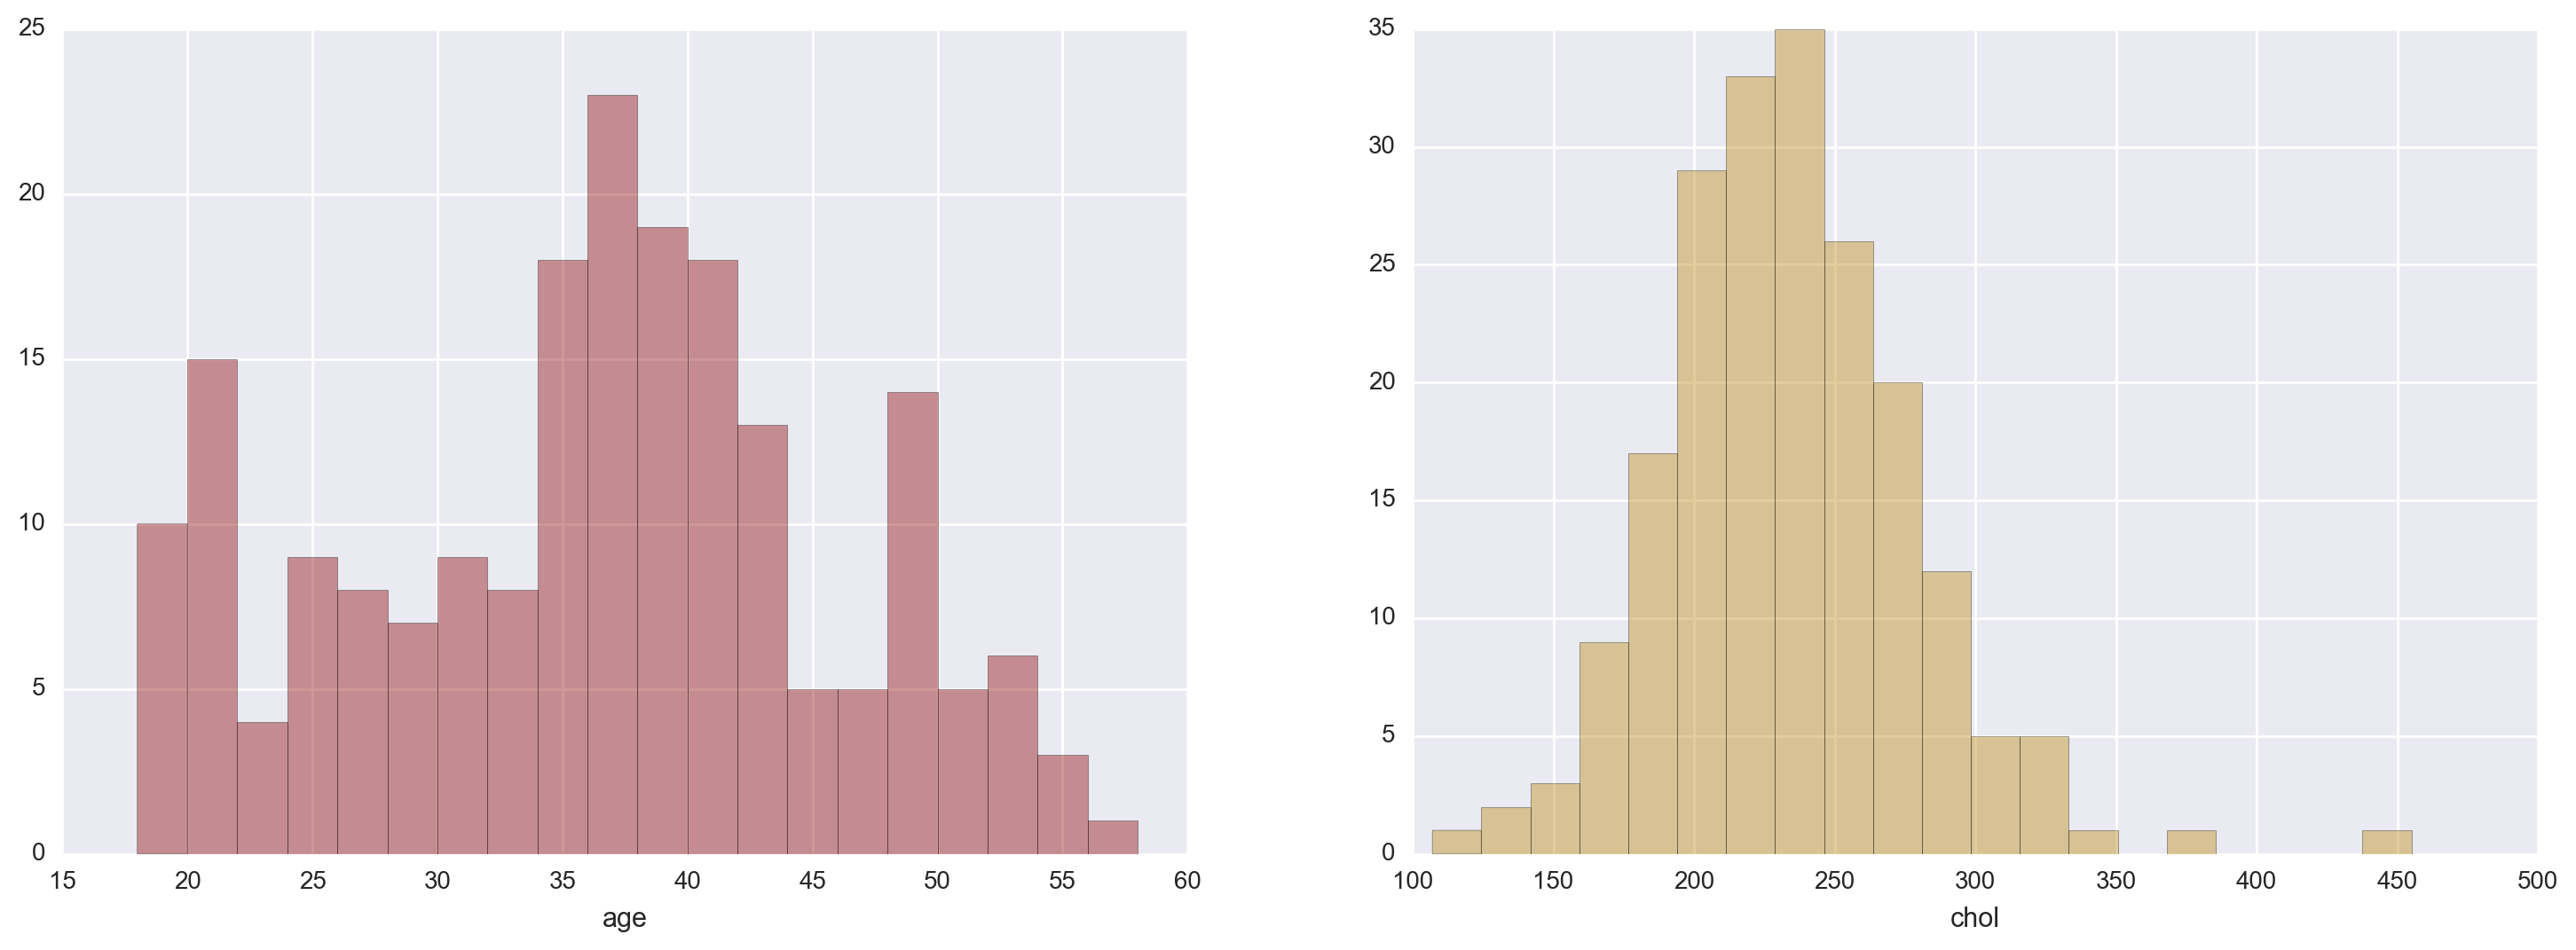

In [88]:
fig, axarr = plt.subplots(1, 2, figsize=(18, 6))

sns.distplot(health_mortality.age, bins=20, hist=True, kde=False, 
             color='darkred', ax=axarr[0], label='Age')


sns.distplot(health_mortality.chol, bins=20, hist=True, kde=False, 
             color='darkgoldenrod', ax=axarr[1], label='Cholesterol')

plt.show()

** Correlation Matrix**

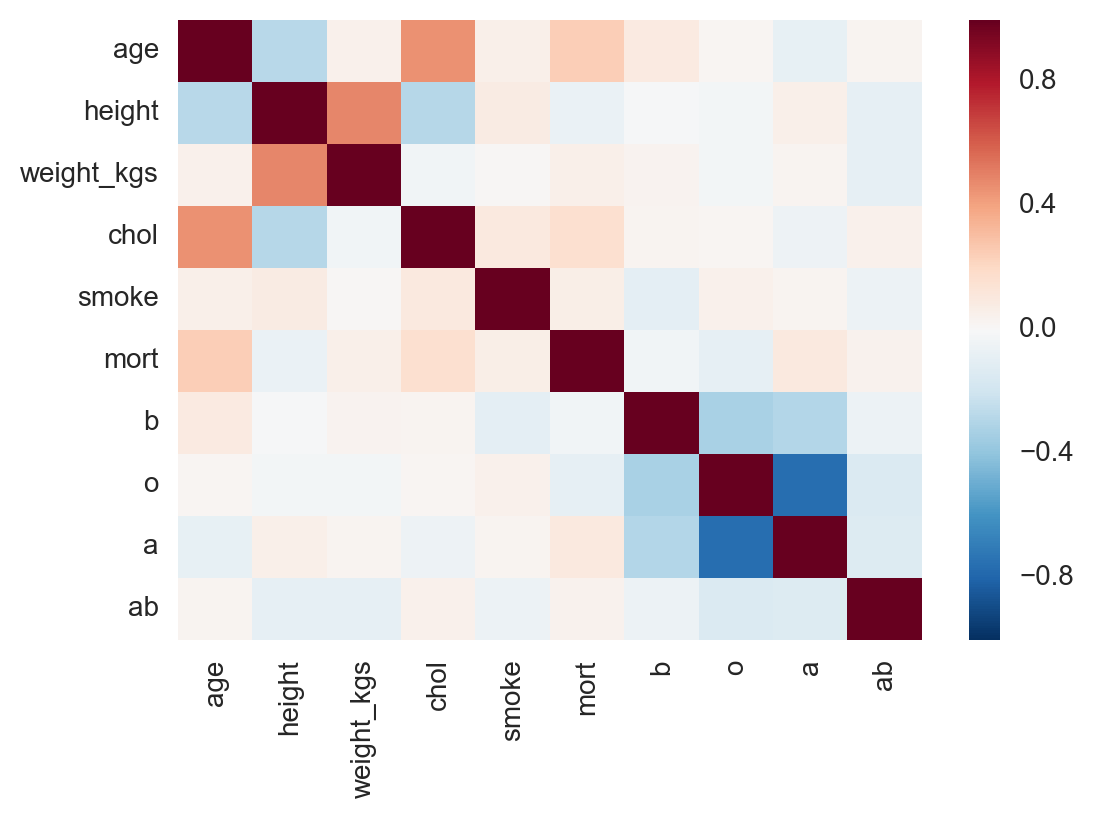

In [89]:
sns.heatmap(health_mortality.corr())

plt.show()

**Mortality of Smokers versus Non-Smokers**

In [90]:
# Initial investigation...only looking at smokers in this case

smokers = np.sum(health_mortality.mort == 1)
smoker_mort = np.sum((health_mortality.smoke == 1) & (health_mortality.mort == 1))
P = round(smoker_mort / float(smokers),2)

print 'Total Smokers: {}'.format(smokers)
print 'P(Smokers-Y & Mort-Y): {}'.format(P)
print 'P(Smokers-N & Mort-Y): {}'.format(1-P)

Total Smokers: 24
P(Smokers-Y & Mort-Y): 0.83
P(Smokers-N & Mort-Y): 0.17


In [91]:
# Now taking both smokers and non-smoker mortality as their own sets

x0 = health_mortality.loc[health_mortality.smoke == 0, 'mort'].values
x1 = health_mortality.loc[health_mortality.smoke == 1, 'mort'].values

The following P-value suggests the null hypothesis (mortality of both sets the same) should not be rejected in favor of the alternate hypothesis

In [92]:
t_stat, p_val, dof = ttest_ind(x0, x1)
print t_stat, p_val, dof

-0.948541802203 0.344009975144 198.0


**If national average weight is 85 pounds, is our weight average significantly different?**

85 pounds is approximately 38.5554 kgs

In [93]:
weight_avg = round(health_mortality.weight_kgs.mean(),2)
weight_std = round(health_mortality.weight_kgs.std(),2)

print '\nAvg Weight: {}'.format(weight_avg)
print 'Std Weight: {}\n'.format(weight_std)
print '85lbs average weight is {} sigmas away from our avg sample weight'.format(round((38.5554 - weight_avg) / weight_std, 2))


Avg Weight: 75.89
Std Weight: 10.44

85lbs average weight is -3.58 sigmas away from our avg sample weight


The P-Value Below gives further evidence that our weight average is significantly different thant 85lbs

In [99]:
d1 = DescrStatsW(health_mortality.weight_kgs)
d1.ttest_mean(38.55)

(50.564333439778572, 1.5851362787360717e-115, 199.0)

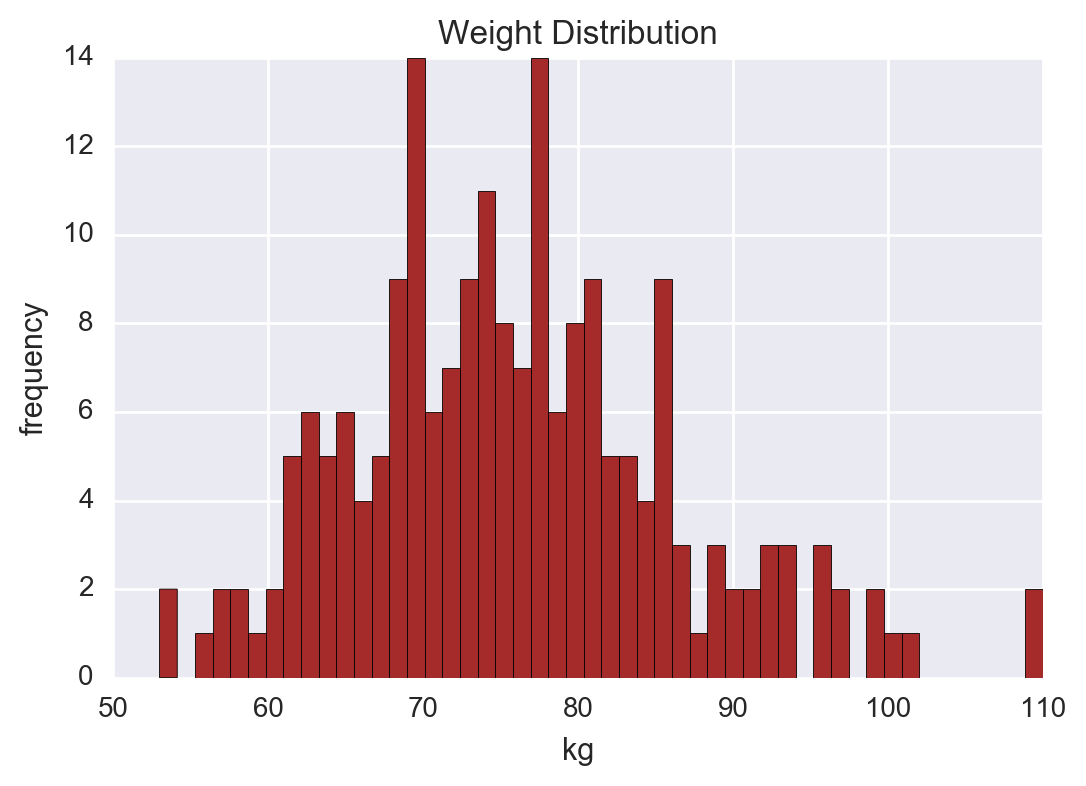

In [94]:
plt.hist(health_mortality.weight_kgs, bins=50, color='brown')
plt.title('Weight Distribution')
plt.xlabel('kg')
plt.ylabel('frequency')
plt.show()